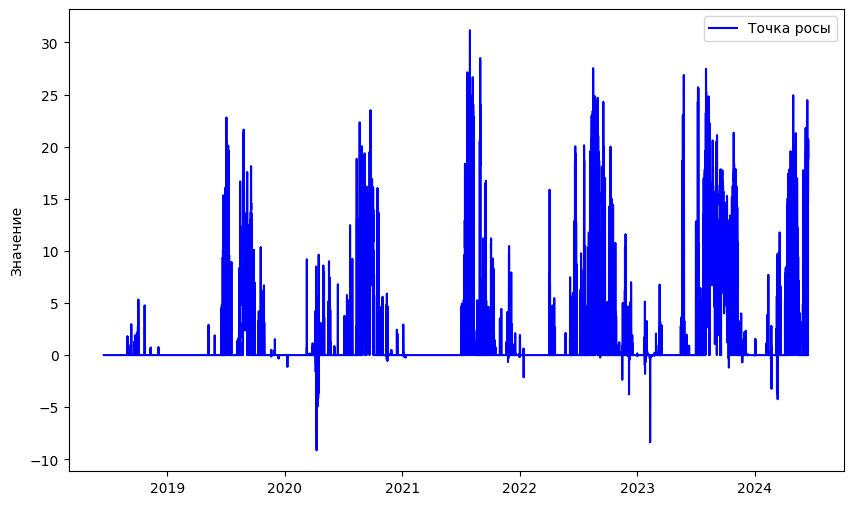

In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("../meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['DEW_POINT']
df = df[required_cols]
df = df.resample('3h').mean()
temp = df['DEW_POINT']

plt.figure(figsize=(10, 6))
plt.plot(df['DEW_POINT'], label='Точка росы', color='blue')

# Настройка графика
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [30]:
# предсказание, основанное не предыдущем суточном дне
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

# Размеры выборок
n = len(df)
train_size = int(n * 0.75)
val_size = int(n * 0.125)
test_size = n - train_size - val_size

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size + val_size], y1[train_size:train_size + val_size]
X_test1, y_test1 = X1[train_size + val_size:], y1[train_size + val_size:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((13140, 24, 1), (13140,), (2190, 24, 1), (2190,), (2167, 24, 1), (2167,))

In [31]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='relu'))
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,009 (246.13 KB)

 Trainable params: 63,009 (246.13 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Настройки обратного вызова и компиляции модели
model_save_path = 'model2/model2-DEW_POINT.keras'
cp2 = ModelCheckpoint(model_save_path, save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
# Обучение модели
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - loss: 13.7634 - root_mean_squared_error: 3.7016 - val_loss: 17.6913 - val_root_mean_squared_error: 4.2061
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 8.1531 - root_mean_squared_error: 2.8482 - val_loss: 12.3483 - val_root_mean_squared_error: 3.5140
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 6.0155 - root_mean_squared_error: 2.4510 - val_loss: 9.8703 - val_root_mean_squared_error: 3.1417
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 5.4248 - root_mean_squared_error: 2.3277 - val_loss: 8.6138 - val_root_mean_squared_error: 2.9349
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 4.9942 - root_mean_squared_error: 2.2341 - val_loss: 7.9089 - val_root_mean_squared_error: 2.8123
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4.7143 - root_mean_squared_error: 2.1708 - val_loss: 7.3437 - val_root_mean_squared_error: 2.7099
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━

In [34]:
# Сохранение всей модели на диск
model_save_path = 'model2/model2-DEW_POINT.keras' 
model2.save(model_save_path)
print(f"Модель сохранена в {model_save_path}")

Модель сохранена в model2/model2-DEW_POINT.keras


In [35]:
from keras.models import load_model
model = load_model('model2/model2-DEW_POINT.keras')

In [36]:
# Прогнозирование на тестовых данных
y_pred = model.predict(X_test1)

# Вывод предсказаний
print(y_pred)

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
[[ 8.707888 ]
 [ 6.07669  ]
 [ 7.5750346]
 ...
 [15.871061 ]
 [16.598837 ]
 [16.54397  ]]


In [37]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=6):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='3h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append(prediction[0, 0])
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = temp.values[-WINDOW_SIZE:]
last_known_dates = temp.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 24
future_dates, predictions = predict_future(model, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
2024-06-15 15:00:00: 16.180755615234375
2024-06-15 18:00:00: 14.996269226074219
2024-06

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


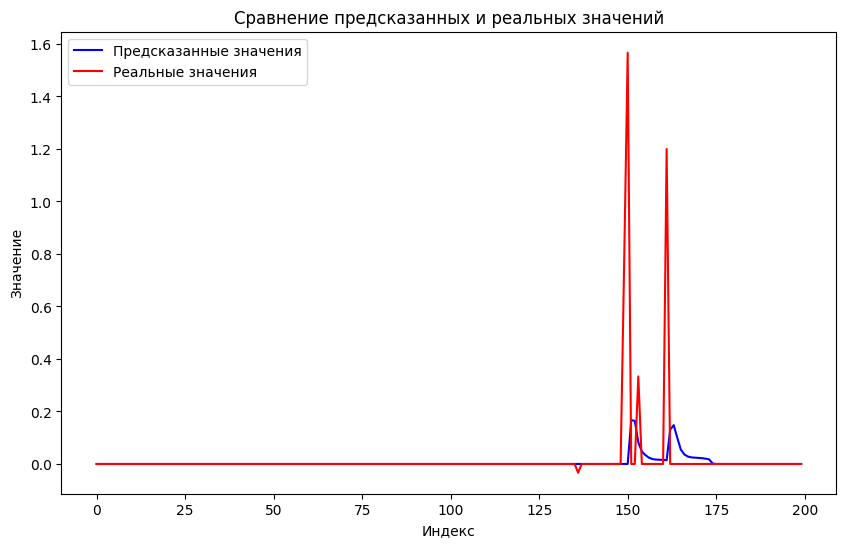

In [38]:
# Предсказание на тестовом наборе данных
y_pred1 = model.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [39]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 1.2422375062622393
Средняя квадратичная ошибка (MSE): 6.894687476604273
Корень из среднеквадратичной ошибки (RMSE): 2.6257736910488445
Коэффициент детерминации (R^2): 0.7161327710179588
